<a href="https://colab.research.google.com/gist/vincentwen1995/07f17ff2e945ba23907f7701202ad605/nlp1-practical-i_kailiang_xiaoxiaowen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Practical 1: Sentiment Detection of Movie Reviews
========================================



This practical concerns sentiment detection of movie reviews.
In [this file](https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json) (80MB) you will find 1000 positive and 1000 negative **movie reviews**.
Each review is a **document** and consists of one or more sentences.

To prepare yourself for this practical, you should
have a look at a few of these texts to understand the difficulties of
the task (how might one go about classifying the texts?); you will write
code that decides whether a random unseen movie review is positive or
negative.

Please make sure you have read the following paper:

>   Bo Pang, Lillian Lee, and Shivakumar Vaithyanathan
(2002). 
[Thumbs up? Sentiment Classification using Machine Learning
Techniques](https://dl.acm.org/citation.cfm?id=1118704). EMNLP.

Bo Pang et al. were the "inventors" of the movie review sentiment
classification task, and the above paper was one of the first papers on
the topic. The first version of your sentiment classifier will do
something similar to Bo Pang’s system. If you have questions about it,
we should resolve them in our first demonstrated practical.


**Advice**

Please read through the entire practical and familiarise
yourself with all requirements before you start coding or otherwise
solving the tasks. Writing clean and concise code can make the difference
between solving the assignment in a matter of hours, and taking days to
run all experiments.

**Environment**

All code should be written in **Python 3**. 
If you use Colab, check if you have that version with `Runtime -> Change runtime type` in the top menu.

> If you want to work in your own computer, then download this notebook through `File -> Download .ipynb`.
The easiest way to
install Python is through downloading
[Anaconda](https://www.anaconda.com/download). 
After installation, you can start the notebook by typing `jupyter notebook filename.ipynb`.
You can also use an IDE
such as [PyCharm](https://www.jetbrains.com/pycharm/download/) to make
coding and debugging easier. It is good practice to create a [virtual
environment](https://docs.python.org/3/tutorial/venv.html) for this
project, so that any Python packages don’t interfere with other
projects.

#### Learning Python 3

If you are new to Python 3, you may want to check out a few of these resources:
- https://learnxinyminutes.com/docs/python3/
- https://www.learnpython.org/
- https://docs.python.org/3/tutorial/

Loading the Data
-------------------------------------------------------------

In [0]:
# download sentiment lexicon (Downloaded)
!wget https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
# download review data (Downloaded)
!wget https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json

--2018-11-23 19:15:27--  https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 662577 (647K) [text/plain]
Saving to: ‘sent_lexicon’

sent_lexicon        100%[===================>] 647.05K  --.-KB/s    in 0.1s    

2018-11-23 19:15:32 (6.54 MB/s) - ‘sent_lexicon’ saved [662577/662577]

--2018-11-23 19:15:33--  https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|151

In [0]:
import math
import os
import sys
from subprocess import call
from nltk import FreqDist
from nltk.util import ngrams
from nltk.stem.porter import PorterStemmer
import sklearn as sk
from google.colab import drive
import pickle
import json
from collections import Counter, defaultdict
import requests
import matplotlib.pyplot as plt
import numpy as np
from decimal import *
from scipy.special import comb
import math
from sklearn import svm
from sklearn.feature_extraction import DictVectorizer

In [0]:
# load reviews into memory
# file structure:
# [
#  {"cv": integer, "sentiment": str, "content": list} 
#  {"cv": integer, "sentiment": str, "content": list} 
#   ..
# ]
# where `content` is a list of sentences, 
# with a sentence being a list of (token, pos_tag) pairs.

# For documentation on POS-tags, see 
# https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf

with open("reviews.json", mode="r", encoding="utf-8") as f:
  reviews = json.load(f)

sent_lex_raw = []
with open("sent_lexicon", mode="r", encoding="utf-8") as f:
  for line in f:
    sent_lex_raw.append(line)

sent_lex = dict()
for line in sent_lex_raw:
  line_parsed = line.split()
  word = line_parsed[2].split('=')[1]
  sentiment = line_parsed[5].split('=')[1]
  sent_lex[word] = sentiment

weighted_sent_lex = dict()
for line in sent_lex_raw:
  line_parsed = line.split()
  word = line_parsed[2].split('=')[1]
  weight = line_parsed[0].split('=')[1]
  weighted_sent_lex[word] = weight

def print_sentence_with_pos(s):
  print(" ".join("%s/%s" % (token, pos_tag) for token, pos_tag in s))

for i, r in enumerate(reviews):
  print(r["cv"], r["sentiment"], len(r["content"]))  # cv, sentiment, num sents
  print_sentence_with_pos(r["content"][0])
  if i == 4: 
    break

c = Counter()
for review in reviews:
  for sentence in review["content"]:
    for token, pos_tag in sentence:
      c[token.lower()] += 1
      
print("#types", len(c))
print("Total number of words: {}".format(sum(c.values())))
print("Most common tokens:")
for token, count in c.most_common(25):
  print("%10s : %8d" % (token, count))
  

0 NEG 29
Two/CD teen/JJ couples/NNS go/VBP to/TO a/DT church/NN party/NN ,/, drink/NN and/CC then/RB drive/NN ./.
1 NEG 11
Damn/JJ that/IN Y2K/CD bug/NN ./.
2 NEG 24
It/PRP is/VBZ movies/NNS like/IN these/DT that/WDT make/VBP a/DT jaded/JJ movie/NN viewer/NN thankful/JJ for/IN the/DT invention/NN of/IN the/DT Timex/NNP IndiGlo/NNP watch/NN ./.
3 NEG 19
QUEST/NN FOR/IN CAMELOT/NNP ``/`` Quest/NNP for/IN Camelot/NNP ''/'' is/VBZ Warner/NNP Bros./NNP '/POS first/JJ feature-length/JJ ,/, fully-animated/JJ attempt/NN to/TO steal/VB clout/NN from/IN Disney/NNP 's/POS cartoon/NN empire/NN ,/, but/CC the/DT mouse/NN has/VBZ no/DT reason/NN to/TO be/VB worried/VBN ./.
4 NEG 38
Synopsis/NNPS :/: A/DT mentally/RB unstable/JJ man/NN undergoing/VBG psychotherapy/NN saves/VBZ a/DT boy/NN from/IN a/DT potentially/RB fatal/JJ accident/NN and/CC then/RB falls/VBZ in/IN love/NN with/IN the/DT boy/NN 's/POS mother/NN ,/, a/DT fledgling/NN restauranteur/NN ./.
#types 47743
Total number of words: 1512359
M

Symbolic approach – sentiment lexicon (2pts)
---------------------------------------------------------------------



**How** could one automatically classify movie reviews according to their

sentiment? 

If we had access to a **sentiment lexicon**, then there are ways to solve
the problem without using Machine Learning. One might simply look up
every open-class word in the lexicon, and compute a binary score
$S_{binary}$ by counting how many words match either a positive, or a
negative word entry in the sentiment lexicon $SLex$.

$$S_{binary}(w_1w_2...w_n) = \sum_{i = 1}^{n}\text{sgn}(SLex\big[w_i\big])$$

**Threshold.** In average there are more positive than negative words per review (~7.13 more positive than negative per review) to take this bias into account you should use a threshold of **8** (roughly the bias itself) to make it harder to classify as positive.

$$
\text{classify}(S_{binary}(w_1w_2...w_n)) = \bigg\{\begin{array}{ll}
        \text{positive} & \text{if } S_{binary}(w_1w_2...w_n) > threshold\\
        \text{negative} & \text{else }
        \end{array}
$$

To implement this approach, you should use the sentiment
lexicon in `sent_lexicon`, which was taken from the
following work:

> Theresa Wilson, Janyce Wiebe, and Paul Hoffmann
(2005). [Recognizing Contextual Polarity in Phrase-Level Sentiment
Analysis](http://www.aclweb.org/anthology/H/H05/H05-1044.pdf). HLT-EMNLP.

#### (Q: 1.1) Implement this approach and report its classification accuracy. (1 pt)

In [0]:
def sgn_slex(priorpolarity):
  if priorpolarity == 'positive':
    return 1
  elif priorpolarity == 'negative':
    return -1
  else:
    return 0

token_results = []
token_correctness = []
token_correct_count = 0
threshold = 8
for index, review in enumerate(reviews):
  s_bin = 0
  for sentence in review["content"]:
    for token, pos_tag in sentence:
      s_bin += sgn_slex(sent_lex.get(token.lower(), "unknown"))
  if s_bin > threshold:
    token_results.append('POS')
    if token_results[-1] == review["sentiment"]:
      token_correct_count += 1
      token_correctness.append('+')
    else:
      token_correctness.append('-')
  else:
    token_results.append('NEG')
    if token_results[-1] == review["sentiment"]:
      token_correct_count += 1
      token_correctness.append('+')
    else:
      token_correctness.append('-')

In [0]:
# token_results: as defined above
token_accuracy = token_correct_count / len(reviews)
print("Rounded accuracy of the binary solution: %0.3f"% token_accuracy)
# print(token_results)
# print(token_correctness)

Rounded accuracy of the binary solution: 0.677


If the sentiment lexicon also has information about the **magnitude** of
sentiment (e.g., *“excellent"* would have higher magnitude than
*“good"*), we could take a more fine-grained approach by adding up all
sentiment scores, and deciding the polarity of the movie review using
the sign of the weighted score $S_{weighted}$.

$$S_{weighted}(w_1w_2...w_n) = \sum_{i = 1}^{n}SLex\big[w_i\big]$$


Their lexicon also records two possible magnitudes of sentiment (*weak*
and *strong*), so you can implement both the binary and the weighted
solutions (please use a switch in your program). For the weighted
solution, you can choose the weights intuitively *once* before running
the experiment.

#### (Q: 1.2) Now incorporate magnitude information and report the classification accuracy. Don't forget to use the threshold. (1 pt)

In [0]:
weight_weak = 0.5
weight_strong = 1.5
magnitude_results = []
magnitude_correctness = []
magnitude_correct_count = 0
threshold = 8
for index, review in enumerate(reviews):
  s_bin = 0
  for sentence in review["content"]:
    for token, pos_tag in sentence:
      if weighted_sent_lex.get(token.lower()) == 'strongsubj':
        s_bin += weight_strong * sgn_slex(sent_lex.get(token.lower(), "unknown"))
      else:
        s_bin += weight_weak * sgn_slex(sent_lex.get(token.lower(), "unknown"))
  if s_bin > threshold:
    magnitude_results.append('POS')
    if magnitude_results[-1] == review["sentiment"]:
      magnitude_correct_count += 1
      magnitude_correctness.append('+')
    else:
      magnitude_correctness.append('-')
  else:
    magnitude_results.append('NEG')
    if magnitude_results[-1] == review["sentiment"]:
      magnitude_correct_count += 1
      magnitude_correctness.append('+')
    else:
      magnitude_correctness.append('-')

In [0]:
# magnitude_results: as defined above
magnitude_accuracy = magnitude_correct_count / len(reviews)
print("Rounded accuracy of the weighted solution: %0.3f"% magnitude_accuracy)
# print(magnitude_results)
# print(magnitude_correctness)

Rounded accuracy of the weighted solution: 0.693


#### Optional: make a barplot of the two results.

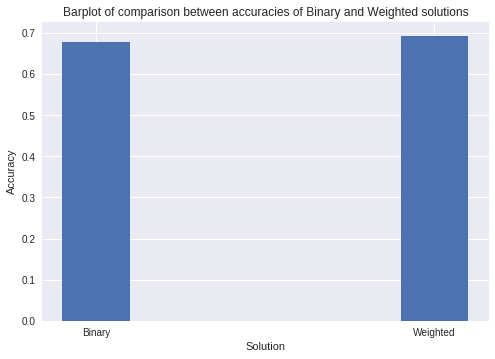

In [0]:
results = {u'Binary':token_accuracy, u'Weighted': magnitude_accuracy}
width = 1/5
plt.bar(range(len(results)), results.values(), width)
plt.xticks(range(len(results)), results.keys())
plt.xlabel("Solution")
plt.ylabel("Accuracy")
plt.title("Barplot of comparison between accuracies of Binary and Weighted solutions")
plt.show()

Answering questions in statistically significant ways (1pt)
-------------------------------------------------------------

Does using the magnitude improve the results? Oftentimes, answering questions like this about the performance of
different signals and/or algorithms by simply looking at the output
numbers is not enough. When dealing with natural language or human
ratings, it’s safe to assume that there are infinitely many possible
instances that could be used for training and testing, of which the ones
we actually train and test on are a tiny sample. Thus, it is possible
that observed differences in the reported performance are really just
noise. 

There exist statistical methods which can be used to check for
consistency (*statistical significance*) in the results, and one of the
simplest such tests is the **sign test**. 

The sign test is based on the binomial distribution. Count all cases when System 1 is better than System 2, when System 2 is better than System 1, and when they are the same. Call these numbers $Plus$, $Minus$ and $Null$ respectively. 

The sign test returns the probability that the null hypothesis is true. 

This probability is called the $p$-value and it can be calculated for the two-sided sign test using the following formula (we multiply by two because this is a two-sided sign test and tests for the significance of differences in either direction):

$$2 \, \sum\limits_{i=0}^{k} \binom{N}{i} \, q^i \, (1-q)^{N-i}$$

where $$N = 2 \Big\lceil \frac{Null}{2}\Big\rceil + Plus + Minus$$ is the total
number of cases, and
$$k = \Big\lceil \frac{Null}{2}\Big\rceil + \min\{Plus,Minus\}$$ is the number of
cases with the less common sign. 

In this experiment, $q = 0.5$. Here, we
treat ties by adding half a point to either side, rounding up to the
nearest integer if necessary. 


#### (Q 2.1): Implement the sign test. Is the difference between the two symbolic systems significant? What is the p-value? (1 pt)

You should use the `comb` function from `scipy` and the `decimal` package for the stable adding of numbers in the final summation.

You can quickly verify the correctness of
your sign test code using a [free online
tool](https://www.graphpad.com/quickcalcs/binomial1.cfm).

In [0]:
def sign_test(results_1, results_2):
  """test for significance
  results_1 is a list of classification results (+ for correct, - incorrect)
  results_2 is a list of classification results (+ for correct, - incorrect)
  """
  ties, plus, minus = 0, 0, 0
  # "-" carries the error
  for i in range(0, len(results_1)):
    if results_1[i]==results_2[i]:
      ties += 1
    elif results_1[i]=="-": 
      plus += 1
    elif results_2[i]=="-": 
      minus += 1
  n = 2 * math.ceil(ties / 2) + plus + minus
  k = math.ceil(ties / 2) + min(plus, minus)
  summation = Decimal(0)
  for i in range(0,k + 1):
    summation += Decimal(comb(n, i, exact=True)) * Decimal(0.5)**Decimal(i) * Decimal(0.5)**Decimal(n-i)
  # use two-tailed version of test
  summation *= 2
  return summation

p_value = sign_test(token_correctness, magnitude_correctness)
print("The difference between the two symbolic systems is", 
        "not significant." if p_value >= 0.05 else "significant.")
print("p_value = %0.8f"% p_value)

The difference between the two symbolic systems is not significant.
p_value = 0.51669780


## Using the Sign test

**From now on, report all differences between systems using the
sign test.** You can think about a change that you apply to one system, as a
 new system.
    
You should report statistical test
results in an appropriate form – if there are several different methods
(i.e., systems) to compare, tests can only be applied to pairs of them
at a time. This creates a triangular matrix of test results in the
general case. When reporting these pair-wise differences, you should
summarise trends to avoid redundancy.


Naive Bayes (8pt + 1pt bonus)
==========


Your second task is to program a simple Machine Learning approach that operates
on a simple Bag-of-Words (BoW) representation of the text data, as
described in Pang et al. (2002). In this approach, the only features we
will consider are the words in the text themselves, without bringing in
external sources of information. The BoW model is a popular way of
representing text information as vectors (or points in space), making it
easy to apply classical Machine Learning algorithms on NLP tasks.
However, the BoW representation is also very crude, since it discards
all information related to word order and grammatical structure in the
original text.

## Writing your own classifier

Write your own code to implement the Naive Bayes (NB) classifier. As
a reminder, the Naive Bayes classifier works according to the following
equation:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} P(c|\bar{f}) = \operatorname*{arg\,max}_{c \in C} P(c)\prod^n_{i=1} P(f_i|c)$$
where $C = \{ \text{POS}, \text{NEG} \}$ is the set of possible classes,
$\hat{c} \in C$ is the most probable class, and $\bar{f}$ is the feature
vector. Remember that we use the log of these probabilities when making
a prediction:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} \Big\{\log P(c) + \sum^n_{i=1} \log P(f_i|c)\Big\}$$

You can find more details about Naive Bayes in [Jurafsky &
Martin](https://web.stanford.edu/~jurafsky/slp3/). You can also look at
this helpful
[pseudo-code](https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html).

*Note: this section and the next aim to put you a position to replicate
    Pang et al., Naive Bayes results. However, the numerical results
    will differ from theirs, as they used different data.*

**You must write the Naive Bayes training and prediction code from
scratch.** You will not be given credit for using off-the-shelf Machine
Learning libraries.

The data contains the text of the reviews, where each document consists
of the sentences in the review, the sentiment of the review and an index
(cv) that you will later use for cross-validation. You will find the
text has already been tokenised and POS-tagged for you. Your algorithm
should read in the text, **lowercase it**, and store the words and their
frequencies in an appropriate data structure that allows for easy
computation of the probabilities used in the Naive Bayes algorithm, and
then make predictions for new instances.

#### (Q3.1) Train your classifier on (positive and negative) reviews with cv-value 000-899, and test it on the remaining reviews cv900–cv999.  Report results using simple classification accuracy as your evaluation metric. Your  features are the word vocabulary. The value of a feature is the count of that feature (word) in the document. (2pts)


In [0]:
def find_prior(reviews, train_split):
  pos_num = 0.0
  neg_num = 0.0  
  for review in reviews:
    if review["cv"] in train_split:
      if review["sentiment"] == "POS":
        pos_num += 1      
      else:
        neg_num += 1
  pos_prior = pos_num / (pos_num + neg_num)
  neg_prior = neg_num / (pos_num + neg_num)
  return pos_prior, neg_prior

def bag_words(reviews, train_split):
  bag = Counter()
  pos_bag = Counter()
  neg_bag = Counter()
  for review in reviews:
    if review["cv"] in train_split:
      if review["sentiment"] == "POS":
        for sentence in review["content"]:
          for token, pos_tag in sentence:
            pos_bag[token.lower()] += 1
            bag[token.lower()] += 1
      else:
        for sentence in review["content"]:
          for token, pos_tag in sentence:
            neg_bag[token.lower()] += 1      
            bag[token.lower()] += 1
  return bag, pos_bag, neg_bag

# Simple heuristics to deal with unseen words with frequency = 0.
def safe_log(x, epsilon=1e-30):
  if x == 0:
    return np.log(epsilon)
  else:
    return np.log(x)

def compute_likelihoods(reviews, bag, pos_bag, neg_bag):  
  likelihoods = defaultdict(lambda: defaultdict(float))
  word_sum_pos = word_sum_neg = 0.0
  for word in set(bag.elements()):
    word_sum_pos += pos_bag[word] 
    word_sum_neg += neg_bag[word]  
  for word in set(bag.elements()):
    likelihoods[word]['POS'] = float(pos_bag[word]) / float(word_sum_pos)
    likelihoods[word]['NEG'] = float(neg_bag[word]) / float(word_sum_neg)
  return likelihoods

def train_NB(reviews, train_split):  
  pos_prior, neg_prior = find_prior(reviews, train_split) 
  bag, pos_bag, neg_bag = bag_words(reviews, train_split)
  likelihoods = compute_likelihoods(reviews, bag, pos_bag, neg_bag)
  return bag, pos_prior, neg_prior, likelihoods

def inference_NB(reviews, bag, pos_prior, neg_prior, likelihoods, valid_split):
  results = defaultdict(lambda: defaultdict(str))
  for review in reviews:
    if review["cv"] in valid_split:
      pos_prob = neg_prob = 0.0
      pos_prob += np.log(pos_prior)
      neg_prob += np.log(neg_prior)
      for sentence in review["content"]:
        for token, pos_tag in sentence:
          if bag[token.lower()] == 0:
            continue
          pos_prob += safe_log(likelihoods[token.lower()]['POS'])
          neg_prob += safe_log(likelihoods[token.lower()]['NEG'])
      if pos_prob > neg_prob:
        results[review["sentiment"]][review["cv"]] = "POS"
      else:
        results[review["sentiment"]][review["cv"]] = "NEG"        
  return results
 
def check_correctness(reviews, results, valid_split):    
  correctness = []
  for c in ["POS", "NEG"]:
    for cv in valid_split:
      if results[c][cv] == c:
        correctness.append('+')
      else:
        correctness.append('-')        
  return correctness

def simple_accuracy(correctness):
  correct_sum = 0.0
  for prediction in correctness:
    if prediction == '+':
      correct_sum += 1    
  return correct_sum / float(len(correctness))

In [0]:
train_split = np.arange(0, 900, 1)
valid_split = np.arange(900, 1000, 1)
bag, pos_prior, neg_prior, likelihoods = train_NB(reviews, train_split)
NB_results = inference_NB(reviews, bag, pos_prior, neg_prior, likelihoods, valid_split)
NB_correctness = check_correctness(reviews, NB_results, valid_split)
NB_accuracy = simple_accuracy(NB_correctness)
print("Rounded Naive Bayes classifier without smoothing accuracy on test_data cv{:03d}-cv{:03d}: {:.03f}".format(valid_split[0], valid_split[-1], NB_accuracy))

Rounded Naive Bayes classifier without smoothing accuracy on test_data cv900-cv999: 0.680


#### (Bonus Questions) Would you consider accuracy to also be a good way to evaluate your classifier in a situation where 90% of your data instances are of positive movie reviews? (1pt)

You can simulate this scenario by keeping the positive reviews
data unchanged, but only using negative reviews cv000–cv089 for
training, and cv900–cv909 for testing. Calculate the classification
accuracy, and explain what changed.

In [0]:
def find_prior_divided(reviews, pos_train_split, neg_train_split):
  pos_num = 0.0
  neg_num = 0.0  
  for review in reviews:
    if review["sentiment"] == "POS":
      if review["cv"] in pos_train_split:      
        pos_num += 1      
    else:
      if review["cv"] in neg_train_split:
        neg_num += 1
  pos_prior = pos_num / (pos_num + neg_num)
  neg_prior = neg_num / (pos_num + neg_num)
  return pos_prior, neg_prior

def bag_words_divided(reviews, pos_train_split, neg_train_split):
  bag = Counter()
  pos_bag = Counter()
  neg_bag = Counter()
  for review in reviews:
    if review["sentiment"] == "POS":
      if review["cv"] in pos_train_split:      
        for sentence in review["content"]:
          for token, pos_tag in sentence:
            pos_bag[token.lower()] += 1
            bag[token.lower()] += 1
    else:
      if review["cv"] in neg_train_split:      
        for sentence in review["content"]:
          for token, pos_tag in sentence:
            neg_bag[token.lower()] += 1      
            bag[token.lower()] += 1
  return bag, pos_bag, neg_bag

def train_NB_divided(reviews, pos_train_split, neg_train_split):  
  pos_prior, neg_prior = find_prior_divided(reviews, pos_train_split, neg_train_split) 
  bag, pos_bag, neg_bag = bag_words_divided(reviews, pos_train_split, neg_train_split)
  likelihoods = compute_likelihoods(reviews, bag, pos_bag, neg_bag)
  return bag, pos_prior, neg_prior, likelihoods
  
def inference_NB_divided(reviews, bag, pos_prior, neg_prior, likelihoods, pos_valid_split, neg_valid_split):
  results = defaultdict(lambda: defaultdict(str))
  for review in reviews:
    if review["sentiment"] == "POS":
      if review["cv"] in pos_valid_split:
        pos_prob = neg_prob = 0.0
        pos_prob += np.log(pos_prior)
        neg_prob += np.log(neg_prior)
        for sentence in review["content"]:
          for token, pos_tag in sentence:
            if bag[token.lower()] == 0:
              continue
            pos_prob += safe_log(likelihoods[token.lower()]['POS'])
            neg_prob += safe_log(likelihoods[token.lower()]['NEG'])
        if pos_prob > neg_prob:
          results[review["sentiment"]][review["cv"]] = "POS"
        else:
          results[review["sentiment"]][review["cv"]] = "NEG"  
    else:
      if review["cv"] in neg_valid_split:
        pos_prob = neg_prob = 0.0
        pos_prob += np.log(pos_prior)
        neg_prob += np.log(neg_prior)
        for sentence in review["content"]:
          for token, pos_tag in sentence:
            if bag[token.lower()] == 0:
              continue
            pos_prob += safe_log(likelihoods[token.lower()]['POS'])
            neg_prob += safe_log(likelihoods[token.lower()]['NEG'])
        if pos_prob > neg_prob:
          results[review["sentiment"]][review["cv"]] = "POS"
        else:
          results[review["sentiment"]][review["cv"]] = "NEG"  
  return results
   
def check_correctness_divided(reviews, results, pos_valid_split, neg_valid_split):    
  correctness = []
  for c in ["POS", "NEG"]:
    if c == "POS":
      for cv in pos_valid_split:
        if results[c][cv] == c:
          correctness.append('+')
        else:
          correctness.append('-')        
    else:
      for cv in neg_valid_split:
        if results[c][cv] == c:
          correctness.append('+')
        else:
          correctness.append('-')        
  return correctness

In [0]:
pos_train_split = np.arange(0, 900, 1)
neg_train_split = np.arange(0, 90, 1)
pos_valid_split = np.arange(900, 1000, 1)
neg_valid_split = np.arange(900, 910, 1)
bag_unbalanced, pos_prior_unbalanced, neg_prior_unbalanced, likelihoods_unbalanced = train_NB_divided(reviews, pos_train_split, neg_train_split)
NB_results_unbalanced = inference_NB_divided(reviews, bag_unbalanced, pos_prior_unbalanced, neg_prior_unbalanced, likelihoods_unbalanced, pos_valid_split, neg_valid_split)
NB_correctness_unbalanced = check_correctness_divided(reviews, NB_results_unbalanced, pos_valid_split, neg_valid_split)
NB_accuracy_unbalanced = simple_accuracy(NB_correctness_unbalanced)
print("Rounded Naive Bayes classifier with unbalanced data accuracy on pos_test_data cv{:03d}-cv{:03d} and neg_test_data cv{:03d}-cv{:03d}: {:.03f}".format(pos_valid_split[0], pos_valid_split[-1], neg_valid_split[0], neg_valid_split[-1], NB_accuracy_unbalanced))

Rounded Naive Bayes classifier with unbalanced data accuracy on pos_test_data cv900-cv999 and neg_test_data cv900-cv909: 0.909


As can be seen above, the resulting accuracy has virtually increased compared to the balanced case, yet however this accuracy is not trustworthy. With unbalanced training set, first the prior belief of the occurences of class "POS" and class "NEG" changes and leans towards the class "POS" in this case. Furthermore, given the fact that there are only 10 documents used for training on class "NEG", the frequencies of the words from the vocabulary are less trustworthy and, therefore, the likelihoods of the words with respect to class "NEG" also change.

These changes finally lead to an overwhelming inference on the class "POS" with a ratio ~10:1, which corresponds to the ratio of the "POS" and "NEG" classes in the training set. In the inference results, since the test set contains 100 "POS" but only 10 "NEG" documents, the accuracy has achieved ~90% even though all the inferences are "POS".

To conclude, when the training/testing sets between different classes are unbalanced, then it is inappropriate to use accuracy as the metric.

## Smoothing

The presence of words in the test dataset that
haven’t been seen during training can cause probabilities in the Naive
Bayes classifier to be $0$, thus making that particular test instance
undecidable. The standard way to mitigate this effect (as well as to
give more clout to rare words) is to use smoothing, in which the
probability fraction
$$\frac{\text{count}(w_i, c)}{\sum\limits_{w\in V} \text{count}(w, c)}$$ for a word
$w_i$ becomes
$$\frac{\text{count}(w_i, c) + \text{smoothing}(w_i)}{\sum\limits_{w\in V} \text{count}(w, c) + \sum\limits_{w \in V} \text{smoothing}(w)}$$





#### (Q3.2) Implement Laplace feature smoothing (1pt)
($smoothing(\cdot) = \kappa$, constant for all words) in your Naive
Bayes classifier’s code, and report the impact on performance. 
Use $\kappa = 1$.

In [0]:
def compute_likelihoods_smoothed(reviews, bag, pos_bag, neg_bag, kappa):  
  likelihoods = defaultdict(lambda: defaultdict(float))
  word_sum_pos = word_sum_neg = 0.0
  for word in set(bag.elements()):
    word_sum_pos += pos_bag[word] + kappa
    word_sum_neg += neg_bag[word] + kappa
  for word in set(bag.elements()):
    likelihoods[word]['POS'] = float(pos_bag[word] + kappa) / float(word_sum_pos)
    likelihoods[word]['NEG'] = float(neg_bag[word] + kappa) / float(word_sum_neg)   
  return likelihoods

def train_NB_smoothed(reviews, train_split, kappa=1):  
  pos_prior, neg_prior = find_prior(reviews, train_split) 
  bag, pos_bag, neg_bag = bag_words(reviews, train_split)
  likelihoods = compute_likelihoods_smoothed(reviews, bag, pos_bag, neg_bag, kappa)
  return bag, pos_prior, neg_prior, likelihoods

def inference_NB_smoothed(reviews, bag, pos_prior, neg_prior, likelihoods, valid_split):
  results = defaultdict(lambda: defaultdict(str))
  for review in reviews:
    if review["cv"] in valid_split:
      pos_prob = neg_prob = 0.0
      pos_prob += np.log(pos_prior)
      neg_prob += np.log(neg_prior)
      for sentence in review["content"]:
        for token, pos_tag in sentence:
          if bag[token.lower()] == 0:
            continue
          pos_prob += np.log(likelihoods[token.lower()]['POS'])
          neg_prob += np.log(likelihoods[token.lower()]['NEG'])
      if pos_prob > neg_prob:
        results[review["sentiment"]][review["cv"]] = "POS"
      else:
        results[review["sentiment"]][review["cv"]] = "NEG"        
  return results

In [0]:
train_split = np.arange(0, 900, 1)
valid_split = np.arange(900, 1000, 1)
kappa = 1
bag_smoothed, pos_prior_smoothed, neg_prior_smoothed, likelihoods_smoothed = train_NB_smoothed(reviews, train_split, kappa)
NB_results_smoothed = inference_NB_smoothed(reviews, bag_smoothed, pos_prior_smoothed, neg_prior_smoothed, likelihoods_smoothed, valid_split)
NB_correctness_smoothed = check_correctness(reviews, NB_results_smoothed, valid_split)
NB_accuracy_smoothed = simple_accuracy(NB_correctness_smoothed)
print("Rounded Naive Bayes classifier with smoothing accuracy on test_data cv{:03d}-cv{:03d}: {:.03f}".format(train_split[0], valid_split[-1], NB_accuracy_smoothed))

Rounded Naive Bayes classifier with smoothing accuracy on test_data cv000-cv999: 0.825


#### (Q3.3) Is the difference between non smoothed (Q3.1) and smoothed (Q3.2) statistically significant? (0.5pt)

In [0]:
p_value_q3 = sign_test(NB_correctness, NB_correctness_smoothed)
print("The difference between non-smoothed (Q3.1) and smoothed (Q3.2) systems is", 
        "not significant." if p_value_q3 >= 0.05 else "significant.")
print("p_value = %0.8f" % p_value_q3)

The difference between non-smoothed (Q3.1) and smoothed (Q3.2) systems is significant.
p_value = 0.04800147


## Cross-validation

A serious danger in using Machine Learning on small datasets, with many
iterations of slightly different versions of the algorithms, is that we
end up with Type III errors, also called the “testing hypotheses
suggested by the data” errors. This type of error occurs when we make
repeated improvements to our classifiers by playing with features and
their processing, but we don’t get a fresh, never-before seen test
dataset every time. Thus, we risk developing a classifier that’s better
and better on our data, but worse and worse at generalizing to new,
never-before seen data.

A simple method to guard against Type III errors is to use
cross-validation. In N-fold cross-validation, we divide the data into N
distinct chunks / folds. Then, we repeat the experiment N times, each
time holding out one of the chunks for testing, training our classifier
on the remaining N - 1 data chunks, and reporting performance on the
held-out chunk. We can use different strategies for dividing the data:

-   Consecutive splitting:
  - cv000–cv099 = Split 1
  - cv100–cv199 = Split 2
  - etc.
  
-   Round-robin splitting (mod 10):
  - cv000, cv010, cv020, … = Split 1
  - cv001, cv011, cv021, … = Split 2
  - etc.

-   Random sampling/splitting
  - Not used here (but you may choose to split this way in a non-educational situation)

#### (Q3.4) Write the code to implement 10-fold cross-validation using round-robin splitting for your Naive Bayes classifier from Q3.2 and compute the 10 accuracies. Report the final performance, which is the average of the performances per fold. If all splits perform equally well, this is a good sign. (1pt)






In [0]:
def round_robin(reviews, folds=10):
  cvs = set()
  sentiments = set()
  for review in reviews:
    cvs.add(review["cv"])
    sentiments.add(review["sentiment"])
  cv_inds = len(cvs)
  splits_x = np.arange(0, cv_inds, folds)
  splits_x = splits_x[np.newaxis, :]
  splits_y = np.arange(folds)
  splits_y = splits_y[:, np.newaxis]
  splits = splits_x + splits_y
  return splits

def NB_classifier_smoothed(reviews, train_split, valid_split, **kwargs):  
  try:
    kappa = kwargs['kappa']    
  except KeyError:
    print('Check input: \'kappa\'')
  bag_smoothed, pos_prior_smoothed, neg_prior_smoothed, likelihoods_smoothed = train_NB_smoothed(reviews, train_split, kappa)
  NB_results_smoothed = inference_NB_smoothed(reviews, bag_smoothed, pos_prior_smoothed, neg_prior_smoothed, likelihoods_smoothed, valid_split)
  NB_correctness_smoothed = check_correctness(reviews, NB_results_smoothed, valid_split)
  NB_accuracy_smoothed = simple_accuracy(NB_correctness_smoothed)
  return NB_results_smoothed, NB_correctness_smoothed, NB_accuracy_smoothed

def cv_rr(reviews, classifier_func, **kwargs):
  round_robin_splits = round_robin(reviews)
  round_robin_results = []
  overall_correctness = []
  for i in np.arange(round_robin_splits.shape[0]):
    train_split = np.empty(shape=(0, 0))
    valid_split = round_robin_splits[i]
    for j in np.arange(round_robin_splits.shape[0]):
      if j == i:
        continue
      else:
        train_split = np.concatenate((train_split, round_robin_splits[j]), axis=None)  
    results, correctness, accuracy = classifier_func(reviews, train_split, valid_split, **kwargs)
    round_robin_results.append(accuracy)     
    overall_correctness.extend(correctness)
  return round_robin_results, overall_correctness

In [0]:
round_robin_NB_smoothed_results, round_robin_NB_smoothed_correctness = cv_rr(reviews, NB_classifier_smoothed, kappa=1)
print("Accuracy per fold:", str(round_robin_NB_smoothed_results))
print('Rounded average accuracy of 10-fold cross-validation with round-robin splitting for smoothed Naive Bayes classifier: {:.03f}'.format(np.mean(round_robin_NB_smoothed_results)))

Accuracy per fold: [0.79, 0.835, 0.805, 0.825, 0.78, 0.845, 0.83, 0.775, 0.83, 0.84]
Rounded average accuracy of 10-fold cross-validation with round-robin splitting for smoothed Naive Bayes classifier: 0.815


#### (Q3.5) Write code to calculate and report variance, in addition to the final performance. (1pt)

**Please report all future results using 10-fold cross-validation now
(unless told to use the held-out test set).**

In [0]:
print('Variance of 10-fold cross-validation with round-robin splitting for smoothed NB classifier: {:.08f}'.format(np.var(round_robin_NB_smoothed_results)))

Variance of 10-fold cross-validation with round-robin splitting for smoothed NB classifier: 0.00060225


## Features, overfitting, and the curse of dimensionality

In the Bag-of-Words model, ideally we would like each distinct word in
the text to be mapped to its own dimension in the output vector
representation. However, real world text is messy, and we need to decide
on what we consider to be a word. For example, is “`word`" different
from “`Word`", from “`word`”, or from “`words`"? Too strict a
definition, and the number of features explodes, while our algorithm
fails to learn anything generalisable. Too lax, and we risk destroying
our learning signal. In the following section, you will learn about
confronting the feature sparsity and the overfitting problems as they
occur in NLP classification tasks.

#### (Q3.6): A touch of linguistics (1pt)

Taking a step further, you can use stemming to
hash different inflections of a word to the same feature in the BoW
vector space. How does the performance of your classifier change when
you use stemming on your training and test datasets? Please use the [Porter stemming
    algorithm](http://www.nltk.org/howto/stem.html) from NLTK.
 Also, you should do cross validation and concatenate the predictions from all folds to compute the significance.

In [0]:
def collect_stems(reviews):
  stemmer = PorterStemmer()
  stems = defaultdict(str)
  for review in reviews:
    for sentence in review["content"]:
      for token, pos_tag in sentence:
        stems[token] = stemmer.stem(token)
  return stems

def bag_words_stem(reviews, train_split, stems):
  bag = Counter()
  pos_bag = Counter()
  neg_bag = Counter()
  for review in reviews:
    if review["cv"] in train_split:
      if review["sentiment"] == "POS":
        for sentence in review["content"]:
          for token, pos_tag in sentence:
            pos_bag[stems[token]] += 1
            bag[stems[token]] += 1
      else:
        for sentence in review["content"]:
          for token, pos_tag in sentence:
            neg_bag[stems[token]] += 1      
            bag[stems[token]] += 1
  return bag, pos_bag, neg_bag

def train_NB_stem(reviews, train_split, stems, kappa=1):
  pos_prior, neg_prior = find_prior(reviews, train_split)  
  bag, pos_bag, neg_bag = bag_words_stem(reviews, train_split, stems)
  likelihoods = compute_likelihoods_smoothed(reviews, bag, pos_bag, neg_bag, kappa)
  return bag, pos_prior, neg_prior, likelihoods

def inference_NB_stem(reviews, bag, pos_prior, neg_prior, likelihoods, valid_split, stems):
  results = defaultdict(lambda: defaultdict(str))
  for review in reviews:
    if review["cv"] in valid_split:
      pos_prob = neg_prob = 0.0
      pos_prob += np.log(pos_prior)
      neg_prob += np.log(neg_prior)
      for sentence in review["content"]:
        for token, pos_tag in sentence:
          if bag[stems[token]] == 0:
            continue
          pos_prob += np.log(likelihoods[stems[token]]['POS'])
          neg_prob += np.log(likelihoods[stems[token]]['NEG'])
      if pos_prob > neg_prob:
        results[review["sentiment"]][review["cv"]] = "POS"
      else:
        results[review["sentiment"]][review["cv"]] = "NEG"
  return results

def NB_classifier_stem(reviews, train_split, valid_split, **kwargs):  
  try:
    kappa = kwargs['kappa']
    stems = kwargs['stems']
  except KeyError:
    print('Check inputs: \'kappa\', \'stems\'')
  bag_stem, pos_prior_stem, neg_prior_stem, likelihoods_stem = train_NB_stem(reviews, train_split, stems, kappa)
  NB_results_stem = inference_NB_stem(reviews, bag_stem, pos_prior_stem, neg_prior_stem, likelihoods_stem, valid_split, stems)
  NB_correctness_stem = check_correctness(reviews, NB_results_stem, valid_split)
  NB_accuracy_stem = simple_accuracy(NB_correctness_stem)
  return NB_results_stem, NB_correctness_stem, NB_accuracy_stem

In [0]:
stems = collect_stems(reviews)
round_robin_NB_stem_results, round_robin_NB_stem_correctness = cv_rr(reviews, NB_classifier_stem, kappa=1, stems=stems)
print("Accuracy per fold:", str(round_robin_NB_stem_results))
print('Rounded average accuracy of 10-fold cross-validation with round-robin splitting for stemmed Naive Bayes classifier: {:.03f}'.format(np.mean(round_robin_NB_stem_results)))

Accuracy per fold: [0.785, 0.84, 0.805, 0.835, 0.77, 0.845, 0.82, 0.775, 0.825, 0.83]
Rounded average accuracy of 10-fold cross-validation with round-robin splitting for stemmed Naive Bayes classifier: 0.813


#### (Q3.7): Is the difference between NB with smoothing and NB with smoothing+stemming significant? (0.5pt)


In [0]:
p_value_stem = sign_test(round_robin_NB_smoothed_correctness, round_robin_NB_stem_correctness)
print("The difference between NB with smoothing and NB with smoothing + stemming is", 
        "not significant." if p_value_stem >= 0.05 else "significant.")
print("p_value = %0.8f" % p_value_stem)

The difference between NB with smoothing and NB with smoothing + stemming is not significant.
p_value = 0.92875078


#### Q3.8: What happens to the number of features (i.e., the size of the vocabulary) when using stemming as opposed to (Q3.2)? (0.5pt)
Give actual numbers. You can use the held-out training set to determine these.

In [0]:
train_split = np.arange(0, 900, 1)
bag_smoothed, _, _ = bag_words(reviews, train_split)
bag_stem, _, _ = bag_words_stem(reviews, train_split, stems)
print('Number of features without stemming: {}'.format(len(bag_smoothed)))
print('Number of features with stemming: {}'.format(len(bag_stem)))

Number of features without stemming: 45348
Number of features with stemming: 32561


#### Q3.9: Putting some word order back in (0.5+0.5pt=1pt)

A simple way of retaining some of the word
order information when using bag-of-words representations is to add **n-grams** features. 
Retrain your classifier from (Q3.4) using **unigrams+bigrams** and
**unigrams+bigrams+trigrams** as features, and report accuracy and statistical significances (in comparison to the experiment at (Q3.4) for all 10 folds, and between the new systems).





In [0]:
def bag_words_bigram(reviews, train_split):
  bag = Counter()
  pos_bag = Counter()
  neg_bag = Counter()
  for review in reviews:
    if review["cv"] in train_split:
      if review["sentiment"] == "POS":
        for sentence in review["content"]:
          for index, (token, pos_tag) in enumerate(sentence):
            pos_bag[token.lower()] += 1
            bag[token.lower()] += 1
            if index < len(sentence) - 1:
              pos_bag[token.lower()+' '+sentence[index+1][0].lower()] += 1
              bag[token.lower()+' '+sentence[index+1][0].lower()] += 1
      else:
        for sentence in review["content"]:
          for index, (token, pos_tag) in enumerate(sentence):
            neg_bag[token.lower()] += 1      
            bag[token.lower()] += 1
            if index < len(sentence) - 1:
              neg_bag[token.lower()+' '+sentence[index+1][0].lower()] += 1
              bag[token.lower()+' '+sentence[index+1][0].lower()] += 1
  return bag, pos_bag, neg_bag

def train_NB_bigram(reviews, train_split, kappa=1):  
  pos_prior, neg_prior = find_prior(reviews, train_split) 
  bag, pos_bag, neg_bag = bag_words_bigram(reviews, train_split)
  likelihoods = compute_likelihoods_smoothed(reviews, bag, pos_bag, neg_bag, kappa)
  return bag, pos_prior, neg_prior, likelihoods

def inference_NB_bigram(reviews, bag, pos_prior, neg_prior, likelihoods, valid_split):
  results = defaultdict(lambda: defaultdict(str))
  for review in reviews:
    if review["cv"] in valid_split:
      pos_prob = neg_prob = 0.0
      pos_prob += np.log(pos_prior)
      neg_prob += np.log(neg_prior)
      for sentence in review["content"]:
        for index, (token, pos_tag) in enumerate(sentence):
          if bag[token.lower()] == 0:
            continue
          pos_prob += np.log(likelihoods[token.lower()]['POS'])
          neg_prob += np.log(likelihoods[token.lower()]['NEG'])
          if index < len(sentence) - 1 and bag[token.lower()+' '+sentence[index+1][0].lower()] != 0:
            pos_prob += np.log(likelihoods[token.lower()+' '+sentence[index+1][0].lower()]['POS'])
            neg_prob += np.log(likelihoods[token.lower()+' '+sentence[index+1][0].lower()]['NEG'])
      if pos_prob > neg_prob:
        results[review["sentiment"]][review["cv"]] = "POS"
      else:
        results[review["sentiment"]][review["cv"]] = "NEG"        
  return results

def NB_classifier_bigram(reviews, train_split, valid_split, **kwargs):  
  try:
    kappa = kwargs['kappa']    
  except KeyError:
    print('Check input: \'kappa\'')
  bag_bigram, pos_prior_bigram, neg_prior_bigram, likelihoods_bigram = train_NB_bigram(reviews, train_split, kappa)
  NB_results_bigram = inference_NB_bigram(reviews, bag_bigram, pos_prior_bigram, neg_prior_bigram, likelihoods_bigram, valid_split)
  NB_correctness_bigram = check_correctness(reviews, NB_results_bigram, valid_split)
  NB_accuracy_bigram = simple_accuracy(NB_correctness_bigram)
  return NB_results_bigram, NB_correctness_bigram, NB_accuracy_bigram

In [0]:
def bag_words_trigram(reviews, train_split):
  bag = Counter()
  pos_bag = Counter()
  neg_bag = Counter()
  for review in reviews:
    if review["cv"] in train_split:
      if review["sentiment"] == "POS":
        for sentence in review["content"]:
          for index, (token, pos_tag) in enumerate(sentence):
            pos_bag[token.lower()] += 1
            bag[token.lower()] += 1
            if index < len(sentence) - 1:
              pos_bag[token.lower()+' '+sentence[index+1][0].lower()] += 1
              bag[token.lower()+' '+sentence[index+1][0].lower()] += 1
            if index < len(sentence) - 2:
              pos_bag[token.lower()+' '+sentence[index+1][0].lower()+' '+sentence[index+2][0].lower()] += 1
              bag[token.lower()+' '+sentence[index+1][0].lower()+' '+sentence[index+2][0].lower()] += 1
      else:
        for sentence in review["content"]:
          for index, (token, pos_tag) in enumerate(sentence):
            neg_bag[token.lower()] += 1      
            bag[token.lower()] += 1
            if index < len(sentence) - 1:
              neg_bag[token.lower()+' '+sentence[index+1][0].lower()] += 1
              bag[token.lower()+' '+sentence[index+1][0].lower()] += 1
            if index < len(sentence) - 2:
              neg_bag[token.lower()+' '+sentence[index+1][0].lower()+' '+sentence[index+2][0].lower()] += 1
              bag[token.lower()+' '+sentence[index+1][0].lower()+' '+sentence[index+2][0].lower()] += 1
  return bag, pos_bag, neg_bag

def train_NB_trigram(reviews, train_split, kappa=1):  
  pos_prior, neg_prior = find_prior(reviews, train_split) 
  bag, pos_bag, neg_bag = bag_words_trigram(reviews, train_split)
  likelihoods = compute_likelihoods_smoothed(reviews, bag, pos_bag, neg_bag, kappa)
  return bag, pos_prior, neg_prior, likelihoods

def inference_NB_trigram(reviews, bag, pos_prior, neg_prior, likelihoods, valid_split):
  results = defaultdict(lambda: defaultdict(str))
  for review in reviews:
    if review["cv"] in valid_split:
      pos_prob = neg_prob = 0.0
      pos_prob += np.log(pos_prior)
      neg_prob += np.log(neg_prior)
      for sentence in review["content"]:
        for index, (token, pos_tag) in enumerate(sentence):
          if bag[token.lower()] == 0:
            continue
          pos_prob += np.log(likelihoods[token.lower()]['POS'])
          neg_prob += np.log(likelihoods[token.lower()]['NEG'])
          if index < len(sentence) - 1 and bag[token.lower()+' '+sentence[index+1][0].lower()] != 0:
            pos_prob += np.log(likelihoods[token.lower()+' '+sentence[index+1][0].lower()]['POS'])
            neg_prob += np.log(likelihoods[token.lower()+' '+sentence[index+1][0].lower()]['NEG'])
          if index < len(sentence) - 2 and bag[token.lower()+' '+sentence[index+1][0].lower()+' '+sentence[index+2][0].lower()] != 0:
            pos_prob += np.log(likelihoods[token.lower()+' '+sentence[index+1][0].lower()+' '+sentence[index+2][0].lower()]['POS'])
            neg_prob += np.log(likelihoods[token.lower()+' '+sentence[index+1][0].lower()+' '+sentence[index+2][0].lower()]['NEG'])
      if pos_prob > neg_prob:
        results[review["sentiment"]][review["cv"]] = "POS"
      else:
        results[review["sentiment"]][review["cv"]] = "NEG"        
  return results

def NB_classifier_trigram(reviews, train_split, valid_split, **kwargs):  
  try:
    kappa = kwargs['kappa']    
  except KeyError:
    print('Check input: \'kappa\'')
  bag_trigram, pos_prior_trigram, neg_prior_trigram, likelihoods_trigram = train_NB_trigram(reviews, train_split, kappa)
  NB_results_trigram = inference_NB_trigram(reviews, bag_trigram, pos_prior_trigram, neg_prior_trigram, likelihoods_trigram, valid_split)
  NB_correctness_trigram = check_correctness(reviews, NB_results_trigram, valid_split)
  NB_accuracy_trigram = simple_accuracy(NB_correctness_trigram)
  return NB_results_trigram, NB_correctness_trigram, NB_accuracy_trigram

In [0]:
round_robin_NB_bigram_results, round_robin_NB_bigram_correctness = cv_rr(reviews, NB_classifier_bigram, kappa=1)
print("Accuracy per fold:", str(round_robin_NB_bigram_results))
print('Rounded average accuracy of 10-fold cross-validation with round-robin splitting for bigram Naive Bayes classifier: {:.03f}'.format(np.mean(round_robin_NB_bigram_results)))

Accuracy per fold: [0.785, 0.84, 0.84, 0.87, 0.8, 0.865, 0.845, 0.845, 0.845, 0.835]
Rounded average accuracy of 10-fold cross-validation with round-robin splitting for bigram Naive Bayes classifier: 0.837


In [0]:
round_robin_NB_trigram_results, round_robin_NB_trigram_correctness = cv_rr(reviews, NB_classifier_trigram, kappa=1)
print("Accuracy per fold:", str(round_robin_NB_trigram_results))
print('Rounded average accuracy of 10-fold cross-validation with round-robin splitting for trigram Naive Bayes classifier: {:.03f}'.format(np.mean(round_robin_NB_trigram_results)))

Accuracy per fold: [0.805, 0.85, 0.835, 0.865, 0.825, 0.85, 0.86, 0.85, 0.855, 0.805]
Rounded average accuracy of 10-fold cross-validation with round-robin splitting for trigram Naive Bayes classifier: 0.840


In [0]:
p_value_bigram = sign_test(round_robin_NB_smoothed_correctness, round_robin_NB_bigram_correctness)
print("The difference between NB with unigram + bigram and NB with smoothing is", 
        "not significant." if p_value_bigram >= 0.05 else "significant.")
print("p_value = %0.8f" % p_value_bigram)
p_value_trigram = sign_test(round_robin_NB_smoothed_correctness, round_robin_NB_trigram_correctness)
print("The difference between NB with unigram + bigram + trigram and NB with smoothing is", 
        "not significant." if p_value_trigram >= 0.05 else "significant.")
print("p_value = %0.8f" % p_value_trigram)
p_value_new = sign_test(round_robin_NB_bigram_correctness, round_robin_NB_trigram_correctness)
print("The difference between NB with unigram + bigram + trigram and NB with unigram + bigram is", 
        "not significant." if p_value_new >= 0.05 else "significant.")
print("p_value = %0.8f" % p_value_new)

The difference between NB with unigram + bigram and NB with smoothing is not significant.
p_value = 0.34777737
The difference between NB with unigram + bigram + trigram and NB with smoothing is not significant.
p_value = 0.28324817
The difference between NB with unigram + bigram + trigram and NB with unigram + bigram is not significant.
p_value = 0.91098294



#### Q3.10: How many features does the BoW model have to take into account now? (0.5pt)
How does this number compare (e.g., linear, square, cubed, exponential) to the number of features at (Q3.8)? 

Use the held-out training set once again for this.


In [0]:
train_split = np.arange(0, 900, 1)
bag_smoothed, _, _ = bag_words(reviews, train_split)
bag_stem, _, _ = bag_words_stem(reviews, train_split, stems)
bag_bigram, _, _ = bag_words_bigram(reviews, train_split)
bag_trigram, _, _ = bag_words_trigram(reviews, train_split)
print('Number of features without stemming: {}'.format(len(bag_smoothed)))
print('Number of features with stemming: {}'.format(len(bag_stem)))
print('Number of features with unigram + bigram: {}, which is around {} times more compared to the number of features at (Q3.8).'.format(len(bag_bigram), int(len(bag_bigram)/len(bag_stem))))
print('Number of features with unigram + bigram + trigram: {}, which is around {} times more compared to the number of features at (Q3.8).'.format(len(bag_trigram), int(len(bag_trigram)/len(bag_stem))))

Number of features without stemming: 45348
Number of features with stemming: 32561
Number of features with unigram + bigram: 465262, which is around 14 times more compared to the number of features at (Q3.8).
Number of features with unigram + bigram + trigram: 1346107, which is around 41 times more compared to the number of features at (Q3.8).


# Support Vector Machines (4pts)


Though simple to understand, implement, and debug, one
major problem with the Naive Bayes classifier is that its performance
deteriorates (becomes skewed) when it is being used with features which
are not independent (i.e., are correlated). Another popular classifier
that doesn’t scale as well to big data, and is not as simple to debug as
Naive Bayes, but that doesn’t assume feature independence is the Support
Vector Machine (SVM) classifier.

You can find more details about SVMs in Chapter 7 of Bishop: Pattern Recognition and Machine Learning.
Other sources for learning SVM:
* http://web.mit.edu/zoya/www/SVM.pdf
* http://www.cs.columbia.edu/~kathy/cs4701/documents/jason_svm_tutorial.pdf
* https://pythonprogramming.net/support-vector-machine-intro-machine-learning-tutorial/







Use the scikit-learn implementation of 
[SVM.](http://scikit-learn.org/stable/modules/svm.html) with the default parameters.



#### (Q4.1): Train SVM and compare to Naive Bayes (2pt)

Train an SVM classifier (sklearn.svm.LinearSVC) using your features. Compare the
classification performance of the SVM classifier to that of the Naive
Bayes classifier from (Q3.4) and report the numbers.
Do cross validation and concatenate the predictions from all folds to compute the significance.  Are the results significantly better?



In [0]:
def vectorize_bow_stem(reviews, bag, train_split, stems, vectorizer):
  train_labels = np.empty([train_split.shape[0] * 2], dtype=np.int)
  ind_review = 0
  bag_reviews = []
  for review in reviews:
    if review["cv"] in train_split:      
      bag_review = Counter()
      for sentence in review["content"]:
        for token, pos_tag in sentence:
          bag_review[stems[token]] += 1
      bag_reviews.append(bag_review)
      if review["sentiment"] == "POS":                        
        train_labels[ind_review] = 1
      else:
        train_labels[ind_review] = 0
      ind_review += 1
  train_vectors = vectorizer.transform(bag_reviews)
  return train_vectors, train_labels

def train_SVM_stem(reviews, train_split, stems):      
  bag, pos_bag, neg_bag = bag_words_stem(reviews, train_split, stems)
  vectorizer = DictVectorizer()
  vocabulary = vectorizer.fit_transform(bag)
  train_vectors, train_labels = vectorize_bow_stem(reviews, bag, train_split, stems, vectorizer)
  classifier = svm.LinearSVC()
  classifier.fit(train_vectors, train_labels)
  return bag, classifier, vectorizer

def inference_SVM_stem(reviews, bag, classifier, valid_split, stems, vectorizer):
  results = defaultdict(lambda: defaultdict(str))    
  for review in reviews:
    if review["cv"] in valid_split:            
      bag_review = Counter()      
      for sentence in review["content"]:
        for token, pos_tag in sentence:
          if bag[stems[token]] == 0:
            continue
          bag_review[stems[token]] += 1
      pred_vector = vectorizer.transform(bag_review)     
      pred_label = classifier.predict(pred_vector)      
      if pred_label == 1:
        results[review["sentiment"]][review["cv"]] = "POS"
      else:
        results[review["sentiment"]][review["cv"]] = "NEG"                  
  return results

def SVM_classifier_stem(reviews, train_split, valid_split, **kwargs):
  try:    
    stems = kwargs['stems']
  except KeyError:
    print('Check input: \'stems\'')
  bag, classifier, vectorizer = train_SVM_stem(reviews, train_split, stems)
  SVM_results_stem = inference_SVM_stem(reviews, bag, classifier, valid_split, stems, vectorizer)
  SVM_correctness_stem = check_correctness(reviews, SVM_results_stem, valid_split)
  SVM_accuracy_stem = simple_accuracy(SVM_correctness_stem)
  return SVM_results_stem, SVM_correctness_stem, SVM_accuracy_stem

In [0]:
stems = collect_stems(reviews)
round_robin_SVM_stem_results, round_robin_SVM_stem_correctness = cv_rr(reviews, SVM_classifier_stem, stems=stems)
print("Accuracy per fold:", str(round_robin_SVM_stem_results))
print('Rounded average accuracy of 10-fold cross-validation with round-robin splitting for stemmed SVM classifier: {:.03f}'.format(np.mean(round_robin_SVM_stem_results)))
p_value_SVM_stem = sign_test(round_robin_NB_smoothed_correctness, round_robin_SVM_stem_correctness)
print("The difference between stemmed SVM classifier and the Naive Bayes classifier with smoothing is", 
        "not significant." if p_value_SVM_stem >= 0.05 else "significant.")
print("p_value = %0.8f" % p_value_SVM_stem)

Accuracy per fold: [0.81, 0.795, 0.795, 0.85, 0.855, 0.82, 0.86, 0.855, 0.885, 0.845]
Rounded average accuracy of 10-fold cross-validation with round-robin splitting for stemmed SVM classifier: 0.837
The difference between stemmed SVM classifier and the Naive Bayes classifier with smoothing is not significant.
p_value = 0.34777737


### More linguistics

Now add in part-of-speech features. You will find the
movie review dataset has already been POS-tagged for you. Try to
replicate what Pang et al. were doing:



####(Q4.2) Replace your features with word+POS features, and report performance with the SVM. Does this help? Do cross validation and concatenate the predictions from all folds to compute the significance. Are the results significant? Why?  (1pt)


In [0]:
def transform_word_pos(token, pos_tag):
  return " ".join("%s/%s" % (token.lower(), pos_tag))

def bag_pos(reviews, train_split):
  bag = Counter()
  pos_bag = Counter()
  neg_bag = Counter()
  for review in reviews:
    if review["cv"] in train_split:
      if review["sentiment"] == "POS":
        for sentence in review["content"]:
          for token, pos_tag in sentence:
            pos_bag[transform_word_pos(token, pos_tag)] += 1
            bag[transform_word_pos(token, pos_tag)] += 1
      else:
        for sentence in review["content"]:
          for token, pos_tag in sentence:
            neg_bag[transform_word_pos(token, pos_tag)] += 1      
            bag[transform_word_pos(token, pos_tag)] += 1
  return bag, pos_bag, neg_bag

def vectorize_pos(reviews, bag, train_split, vectorizer):
  train_labels = np.empty([train_split.shape[0] * 2], dtype=np.int)
  ind_review = 0
  bag_reviews = []
  for review in reviews:
    if review["cv"] in train_split:      
      bag_review = Counter()
      for sentence in review["content"]:
        for token, pos_tag in sentence:
          bag_review[transform_word_pos(token, pos_tag)] += 1
      bag_reviews.append(bag_review)
      if review["sentiment"] == "POS":                        
        train_labels[ind_review] = 1
      else:
        train_labels[ind_review] = 0
      ind_review += 1
  train_vectors = vectorizer.transform(bag_reviews)
  return train_vectors, train_labels

def train_SVM_pos(reviews, train_split):      
  bag, pos_bag, neg_bag = bag_pos(reviews, train_split)
  vectorizer = DictVectorizer()
  vocabulary = vectorizer.fit_transform(bag)
  train_vectors, train_labels = vectorize_pos(reviews, bag, train_split, vectorizer)
  classifier = svm.LinearSVC()
  classifier.fit(train_vectors, train_labels)
  return bag, classifier, vectorizer

def inference_SVM_pos(reviews, bag, classifier, valid_split, vectorizer):
  results = defaultdict(lambda: defaultdict(str))    
  for review in reviews:
    if review["cv"] in valid_split:            
      bag_review = Counter()      
      for sentence in review["content"]:
        for token, pos_tag in sentence:
          if bag[transform_word_pos(token, pos_tag)] == 0:
            continue
          bag_review[transform_word_pos(token, pos_tag)] += 1
      pred_vector = vectorizer.transform(bag_review)
      pred_label = classifier.predict(pred_vector)      
      if pred_label == 1:
        results[review["sentiment"]][review["cv"]] = "POS"
      else:
        results[review["sentiment"]][review["cv"]] = "NEG"                  
  return results

def SVM_classifier_pos(reviews, train_split, valid_split, **kwargs):  
  bag, classifier, vectorizer = train_SVM_pos(reviews, train_split)
  SVM_results_pos = inference_SVM_pos(reviews, bag, classifier, valid_split, vectorizer)
  SVM_correctness_pos = check_correctness(reviews, SVM_results_pos, valid_split)
  SVM_accuracy_pos = simple_accuracy(SVM_correctness_pos)
  return SVM_results_pos, SVM_correctness_pos, SVM_accuracy_pos

In [0]:
round_robin_SVM_pos_results, round_robin_SVM_pos_correctness = cv_rr(reviews, SVM_classifier_pos)
print("Accuracy per fold:", str(round_robin_SVM_pos_results))
print('Rounded average accuracy of 10-fold cross-validation with round-robin splitting for SVM classifier with POS features: {:.03f}'.format(np.mean(round_robin_SVM_pos_results)))
p_value_pos = sign_test(round_robin_NB_smoothed_correctness, round_robin_SVM_pos_correctness)
print("The difference between SVM classifier with POS features and the Naive Bayes classifier with smoothing is", 
        "not significant." if p_value_pos >= 0.05 else "significant.")
print("p_value = %0.8f" % p_value_pos)

Accuracy per fold: [0.82, 0.795, 0.825, 0.84, 0.84, 0.845, 0.855, 0.855, 0.865, 0.84]
Rounded average accuracy of 10-fold cross-validation with round-robin splitting for SVM classifier with POS features: 0.838
The difference between SVM classifier with POS features and the Naive Bayes classifier with smoothing is not significant.
p_value = 0.32530107


#### (Q4.3) Discard all closed-class words from your data (keep only nouns (N*), verbs (V*), adjectives (J*) and adverbs (RB*)), and report performance. Does this help? Do cross validation and concatenate the predictions from all folds to compute the significance. Are the results significantly better than when we don't discard the closed-class words? Why? (1pt)

In [0]:
def bag_pos_part(reviews, train_split, pos_tags):
  bag = Counter()
  pos_bag = Counter()
  neg_bag = Counter()
  for review in reviews:
    if review["cv"] in train_split:
      if review["sentiment"] == "POS":
        for sentence in review["content"]:
          for token, pos_tag in sentence:
            if pos_tag in pos_tags:
              pos_bag[transform_word_pos(token, pos_tag)] += 1
              bag[transform_word_pos(token, pos_tag)] += 1
      else:
        for sentence in review["content"]:
          for token, pos_tag in sentence:
            if pos_tag in pos_tags:
              neg_bag[transform_word_pos(token, pos_tag)] += 1      
              bag[transform_word_pos(token, pos_tag)] += 1
  return bag, pos_bag, neg_bag

def vectorize_pos_part(reviews, bag, train_split, vectorizer, pos_tags):
  train_labels = np.empty([train_split.shape[0] * 2], dtype=np.int)
  ind_review = 0
  bag_reviews = []
  for review in reviews:
    if review["cv"] in train_split:      
      bag_review = Counter()
      for sentence in review["content"]:
        for token, pos_tag in sentence:
          if pos_tag in pos_tags:
            bag_review[transform_word_pos(token, pos_tag)] += 1
      bag_reviews.append(bag_review)
      if review["sentiment"] == "POS":                        
        train_labels[ind_review] = 1
      else:
        train_labels[ind_review] = 0
      ind_review += 1
  train_vectors = vectorizer.transform(bag_reviews)
  return train_vectors, train_labels

def train_SVM_pos_part(reviews, train_split, pos_tags):      
  bag, pos_bag, neg_bag = bag_pos_part(reviews, train_split, pos_tags)
  vectorizer = DictVectorizer()
  vocabulary = vectorizer.fit_transform(bag)
  train_vectors, train_labels = vectorize_pos_part(reviews, bag, train_split, vectorizer, pos_tags)
  classifier = svm.LinearSVC()
  classifier.fit(train_vectors, train_labels)
  return bag, classifier, vectorizer

def inference_SVM_pos_part(reviews, bag, classifier, valid_split, vectorizer, pos_tags):
  results = defaultdict(lambda: defaultdict(str))    
  for review in reviews:
    if review["cv"] in valid_split:            
      bag_review = Counter()      
      for sentence in review["content"]:
        for token, pos_tag in sentence:
          if pos_tag in pos_tags:
            if bag[transform_word_pos(token, pos_tag)] == 0:
              continue
            bag_review[transform_word_pos(token, pos_tag)] += 1
      pred_vector = vectorizer.transform(bag_review)
      pred_label = classifier.predict(pred_vector)      
      if pred_label == 1:
        results[review["sentiment"]][review["cv"]] = "POS"
      else:
        results[review["sentiment"]][review["cv"]] = "NEG"                  
  return results

def SVM_classifier_pos_part(reviews, train_split, valid_split, **kwargs):  
  pos_tags = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS', 'RB', 'RBR', 'RBS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WRB')
  bag, classifier, vectorizer = train_SVM_pos_part(reviews, train_split, pos_tags)
  SVM_results_pos_part = inference_SVM_pos_part(reviews, bag, classifier, valid_split, vectorizer, pos_tags)
  SVM_correctness_pos_part = check_correctness(reviews, SVM_results_pos_part, valid_split)
  SVM_accuracy_pos_part = simple_accuracy(SVM_correctness_pos_part)
  return SVM_results_pos_part, SVM_correctness_pos_part, SVM_accuracy_pos_part

In [0]:
round_robin_SVM_pos_part_results, round_robin_SVM_pos_part_correctness = cv_rr(reviews, SVM_classifier_pos_part)
print("Accuracy per fold:", str(round_robin_SVM_pos_part_results))
print('Rounded average accuracy of 10-fold cross-validation with round-robin splitting for SVM classifier without closed-class words: {:.03f}'.format(np.mean(round_robin_SVM_pos_part_results)))
p_value_pos_part = sign_test(round_robin_NB_smoothed_correctness, round_robin_SVM_pos_part_correctness)
print("The difference between SVM classifier without closed-class words and the Naive Bayes classifier with smoothing is", 
        "not significant." if p_value_pos_part >= 0.05 else "significant.")
print("p_value = %0.8f" % p_value_pos_part)

Accuracy per fold: [0.82, 0.83, 0.84, 0.86, 0.845, 0.835, 0.88, 0.86, 0.865, 0.82]
Rounded average accuracy of 10-fold cross-validation with round-robin splitting for SVM classifier without closed-class words: 0.846
The difference between SVM classifier without closed-class words and the Naive Bayes classifier with smoothing is not significant.
p_value = 0.18706189


# (Q8) Discussion (max. 500 words). (5pts)

> Based on your experiments, what are the effective features and techniques in sentiment analysis? What information do different features encode?
Why is this important? What are the limitations of these features and techniques?
 


In this practical, both symbolic and Machine Learning approaches with several techniques and features are developed and to perform sentiment analysis on movie reviews.

The symbolic systems of using sentiment lexicons with and without magnitude weights give an accuracy of 0.677 and 0.693 respectively, where the difference is not significant. In these two systems, only information on the number of words from the sentiment lexicons included in the reviews are exploited, so the implementation of these systems is simple and the program execution is fast. However, the limitation of the symbolic approach is that it does not exploit any linguistics from the review contents and, thus, is weak at distinguishing grammars like negation or double negation.

As for the Machine Learning approach, first, the two versions of NB classifier are compared (i.e. unsmoothed and smoothed). In a word, the performance of the unsmoothed NB classifier is significantly poorer than the smoothed one (0.680 and 0.825 respectively), even if the former is implemented with some simple heuristics (i.e. replacing log(0) with a large negative number). The limitation of the unsmoothed NB classifier is that it cannot handle data sparsity, which is common under this scenario.

In order to avoid overfitting, on the basis of NB classifier with smoothing, 10-fold cross-validation is used, which gives an overall accuracy of 0.815. As a hypothesized improvement on the performance, the original word features are stemmed to reduce the dimension of the features. However, the result turns out that using the Porter stemming algorithm does not improve the overall classification accuracy (i.e. 0.813). This does not necessarily mean that stemming is an ineffective technique, but might just be the limitation of the specific stemming algorithm. Besides, the effect of adopting bigram and trigram features are experimented, which both give higher (although not significant) accuracies. More specifically, the system with unigram + bigram features gives an overall accuracy of 0.837, and the system with unigram + bigram + trigram features gives an overall accuracy of 0.840. When using higher-gram features, the dependencies between the words are encoded, hence, the linguistics within the review contents are exploited. The major limitation of higher-gram features is that they lead to an "exponential" increase in the total number of features, which requires more computational effort.

The linear SVM classifier is implemented using the stemmed unigram features with and without the POS information, where the respective accuracies are 0.838 and 0.846. According to the sign-test results, the increased accuracies of the two SVM classifiers are not significantly different from that of the NB classifier with unigram features. Compared to the NB classifier, the correlations between the unigram features in the reviews, together with the linguistics when using POS-tags, are encoded, which leads to a "better" accuracy. However, the limitation of the linear SVM classifier is that it assumes the two classes of review sentiments are linearly separable, which might not be the case. Also, due to the large feature size, the computational effort is hugely increased compared to the NB classifier.

# Submission 


In [0]:
# Write your names and student numbers here:
# Kai Liang 12046477
# Xiaoxiao Wen 12320323

**That's it!**

- Check if you answered all questions fully and correctly. 
- Download your completed notebook using `File -> Download .ipynb` 
- Also save your notebook as a Github Gist. Get it by choosing `File -> Save as Github Gist`.  Make sure that the gist has a secret link (not public).
- Check if your answers are all included in the file you submit (e.g. check the Github Gist URL)
- Submit your .ipynb file and link to the Github Gist via *Canvas*. One submission per group. 